# Case 3. Patient Drug Review
Mr.Pasin Jiratthitcheep<br>
Last edited: 17.03.2019<br>
Cognitive Systems for Health Technology Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

## 0. Table of contents

1. Objectives
2. Required libraries
3. Data description and preprocessing
    * Training set
    * Split train and validation set
    * Compute class-weight for training precess
    * Define training and ploting functions
4. Modeling and compilation
    * Model 1 : Embedding + Conv1D + LSTM (original)
    * Model 2 : Embedding + Conv1D + LSTM (modified)
    * Model 3 : Embedding + Conv1D + Stack of GRU
    * Model 4 : Embedding + Conv1D + Bidirectional LSTM
5. Training and Validation
    * Training Model 1 : Embedding + Conv1D + LSTM (original)
    * Training Model 2 : Embedding + Conv1D + LSTM (modified)
    * Training Model 3 : Embedding + Conv1D + Stack of GRU
    * Training Model 4 : Embedding + Conv1D + Bidirectional LSTM
6. Evaluation
    * Selcetion the best of all
    * Defining my preprocess function
    * Word2Vec embedding
    * Comparing Without preprocess / Preprocess / Word2Vec
7. Results and discussion
    * Final model with test set
8. Conclusions

## 1. Objectives

This notebook was created for learning to use neural networks to process text data and predict ratings associated to the text. The study case is about patient drug reviews extracted from Drugs.com. Patient reviews on specific drugs along with related conditions and a 10 star patient rating reflecting overall patient satisfaction.

## 2. Required libraries

In [1]:
# Import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pickle
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import gensim
import os

import keras
from keras import backend as K
from keras import layers
from keras import models
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Activation, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU, Bidirectional, Flatten, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.models import Model, load_model, Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.initializers import Constant
from keras import regularizers

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight
import warnings

# Library for text cleaning
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
import itertools

Using TensorFlow backend.


## 3. Data description and preprocessing

I used a dataset from https://www.kaggle.com/jessicali9530/kuc-hackathon-winter-2018/home that was used for the Winter 2018 Kaggle University Club Hackathon.

Data was devided into 2 files (drugsComTrain_raw.csv and drugsComTest_raw.csv) those contain Patient reviews on specific drugs along with related conditions and a 10 star patient rating reflecting overall patient satisfaction. The drugsComTrain_raw.csv contains totally 161,297 records and the drugsComTest_raw.csv contains 53,766 records.

Columns of both CSV files:

* uniqueID = Unique ID
* drugName = Name of drug
* condition = Name of condition
* review = Patient review
* rating = 10 star patient rating
* date = Date of review entry
* usefulCount = Number of users who found review useful

### Training set

I used drugsComTrain_raw.csv as training-set and validation-set. First, I imported data from drugsComTrain_raw.csv and group rating into 3 classes.
* <b>Negative (0) = rating 0 - 4
* Natural (1) = rating 5 - 6
* Positive (2) = rating 7 - 10</b>

Then, I collected those categories into 'label' column.

In [2]:
# Read the training data
data = pd.read_csv(r'./drugsComTrain_raw.csv')

# Create labels
r = data['rating']
r_replace = r.replace({ 0 : 0, 1 : 0, 2: 0, 3: 0, 4: 0 })
r_replace = r_replace.replace({ 5 : 1, 6 : 1})
r_replace = r_replace.replace({ 7 : 2, 8 : 2, 9 : 2, 10 : 2})

# Add the label column to the data
data['label'] = r_replace

# Check the new data
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,label
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,2
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,2
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,1
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,2
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,2


I checked distribution of each class to make sure should I do something if the data is unbalance.

2    106866
0     40075
1     14356
Name: label, dtype: int64


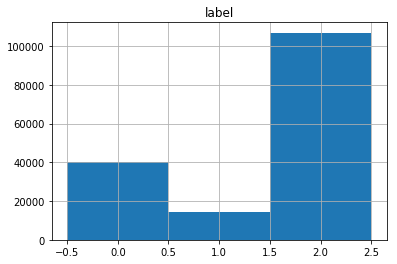

In [3]:
# Plot distribution of labels
data.hist(column = 'label', bins = np.arange(0, 4), align = 'left');
print(data['label'].value_counts())

As you can see from the above histogram, most of data is in 'Positive class' and it much more than data in 'Natural class'. Using balanced data by ramdom equally select each class, seem not to be a good choice because the smallest class ( Natural class ) has only 14,356 records. If we select 14,356 records for each class, we will get only 43,068 records that quite too small for training model. So, <b>I choose to define class_weight for each class to help to avoid training a bias model</b> after using imbalance data. (I will calculate class_weight after split training-set and validation-set)

Next, I plotted length of review to find size of sentence that proper for this dataset.

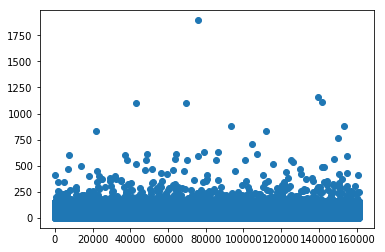

,0
count,161297.000000
mean,84.699802
std,45.044833
min,1.000000
25%,48.000000
50%,84.000000
75%,126.000000
max,1894.000000


In [4]:
# Getting lenght of each review
length = []
for x in data['review'].values:
    length.append(len(x.split()))
    
# Plot distribution of length
plt.scatter(x = range(len(length)), y = length)
plt.show()

# Show statistic of length
pd.DataFrame(length).describe()

### Split train and validation set

I defined most of variables here. For max_len, I have tried several values (125, 250, 1900) to the best one and I got 500 is the best value for my model. Also for max_feature and embedded_dim, 10000 words for training and 100 dimension of word vector get the best result from my experiment.

In [5]:
# Define Variable
seed = 24 # for randomly split train - validation
max_len = 500 # maximum length of sentence
max_feature = 10000 # number of word that will be used to train
validate_size = 3000

batch_size = 512
epochs = 100
embedded_dim = 100

<b>I decided to use balanced validation-set</b> because I believe that if we use imbalance validation-set and our model is bias model to some classes, it may get high accuracy than another model that doesn't have bias.

This is how I create my balanced validation-set. I group the dataframe by level column first and then sample each of them with the equal size.

In [6]:
# Group records by level feature
g = data.groupby('label')

# Sample records equal to SIZE//2 for each group for balancing the dataset
val_df = g.apply(lambda x: x.sample(validate_size//3, random_state = seed))

# Convert the labels to one_hot_category values
one_hot_labels_val = to_categorical(val_df['label'].values, num_classes = 3)

# Show distribution of datset for each class
print("How many records for each class in validation set (after balancing)")
val_df['label'].value_counts()

How many records for each class in validation set (after balancing)


1    1000
2    1000
0    1000
Name: label, dtype: int64

After split 3,000 records as validation set, I drop those records from the main dataframe so the rest is uesd as training set (158,297 records). Then, I encoded label into one-hot form to use in training process.

In [7]:
# The rest of balanced validation set is training set
train_df = data.drop(val_df.index.levels[1])

# Convert the labels to one_hot_category values
one_hot_labels_train = to_categorical(train_df['label'].values, num_classes = 3)

Tokenization is how we break down text into such tokens (word, characters, or n-grams). Like all other neural networks, deep-learning models don’t take as input raw text (they only work with numeric tensors). Vectorizing text is the process of transforming text into numeric tensors. All text-vectorization processes consist of applying some tokenization scheme and then associating numeric vectors with the generated tokens.

After we 'fit' text to the tokenizer, we generate index that represent each word (the same wrod in different sentense will use the same index). And 'text_to_sequences' transform sentence into a vector that use those indexes of word to represent word in sentences in order.

'pad_sequences' is uesd to make each vector has thesame size by adding more zero or cut off the rest.

In [8]:
# Read a part of the reviews and create training sequences (x_train)
tokenizer = Tokenizer(num_words = max_feature)
tokenizer.fit_on_texts(data['review'])

X_train_normal = pad_sequences(tokenizer.texts_to_sequences(train_df['review']), maxlen = max_len)
X_val_normal = pad_sequences(tokenizer.texts_to_sequences(val_df['review']), maxlen = max_len)

### Compute class_weight for training process

I use compute_class_weight function from scikitlearn library to <b>estimate class weights for unbalanced datasets</b>. We will use it when we fit model.

In [9]:
class_weights = class_weight.compute_class_weight("balanced", [0,1,2], train_df['label'].values)
class_weight_dict = {0: class_weights[0], 1: class_weights[1], 2: class_weights[2]}
class_weight_dict

{0: 1.3503689486031136, 1: 3.950708795048418, 2: 0.49841938551250325}

### Define training and ploting functions

In [10]:
# Similarly create a function for model training, for demonstration purposes we use constant values
def train_model(model, x, y, vs, cb, model_name, last_path, his_path, e = epochs, bs = batch_size, ie = 0):
    # Start timing
    start = time.time()

    # Training
    print('Training ', model_name, '...')
    h = model.fit(x, y, epochs = e, batch_size = bs, verbose = 1,
                  validation_data = vs, callbacks = cb, class_weight=class_weight_dict, initial_epoch=ie)
    
    stop = time.time()
    etime = stop - start
    print('Done. Elapsed time {:.0f} seconds for {:} epochs, average {:.1f} seconds/epoch.'.format(etime, e, etime/e))

    # Save last model
    model.save(last_path)
    
    # Save the history
    with open(his_path, 'wb') as file_pi:
        pickle.dump(h.history, file_pi)
    return h

In [11]:
# We use the same plotting commands several times, so create a function for that purpose
def plot_history(history, path_baseline="100_his_m1"):
    # Load baseline history from file
    with open(path_baseline, "rb") as input_file:
        baseline_model = pd.DataFrame(pickle.load(input_file))

    f, ax = plt.subplots(1, 2, figsize = (16, 7))
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    base_val_acc = baseline_model['val_acc']
    base_val_loss = baseline_model['val_loss']
    base_acc = baseline_model['acc']
    base_loss = baseline_model['loss']

    epochs = range(1, len(acc) + 1)
    
    plt.sca(ax[0])
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.plot(epochs, base_acc, 'r:', label='Baseline model acc')
    plt.plot(epochs, base_val_acc, 'r--', label='Baseline model validation acc')
    plt.title('Training and validation accuracy')
    plt.ylim([0, 1])
    plt.legend()

    plt.sca(ax[1])
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.plot(epochs, base_loss, 'r:', label='Baseline model loss')
    plt.plot(epochs, base_val_loss, 'r--', label='Baseline model validation loss')
    plt.title('Training and validation loss')
    plt.ylim([0, 3])
    plt.legend()

    plt.show()

## 4. Modeling and compilation

Actually, I already tried to use multiple of architecture, some models work well and some doesn't (as you can see from my draft notebook here).

So I ended up with follwing 4 models that I select to show in this notebok:

1. Embedding + Conv1D + LSTM (original)
2. Embedding + Conv1D + LSTM (modified)
3. Embedding + Conv1D + Stack of GRU
4. Embedding + Conv1D + Bidirectional LSTM


** you can see my tests from <a href="https://github.com/pasinJ/cognitive-systems-for-healthtechnology-applications/blob/master/Case%203%20%20First%20Trial.ipynb">my draft notebook</a> (without comments) if you want **

### Model 1 : Embedding + Conv1D + LSTM (original)

I got idea of this model from the last example model in 'Week 7' guideline notebook. After some tuning parameters and try many architectures of model, this got the <b>high accuracy model but the loss function showed very quick overfitting</b>. So, I set <b>this model as the baseline</b> and use it to compare with other models.

The structure of model 1 is showed as following:

In [12]:
m1 = Sequential()
m1.add(Embedding(max_feature, embedded_dim, input_length = max_len))
m1.add(Conv1D(32, 7, activation='relu'))
m1.add(MaxPooling1D(5))
m1.add(Conv1D(32, 7, activation='relu'))
m1.add(LSTM(8, dropout = 0.5, recurrent_dropout = 0.5))
m1.add(Dropout(0.5))
m1.add(Dense(3, activation = 'softmax'))
m1.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           22432     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 1312      
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total para

### Model 2 : Embedding + Conv1D + LSTM (modified)

This model was modified from the first model by <b>adding more 'Dropout layer' to fight with overfitting</b> scenario. I increased size of filter in 'Conv1D layer' before adding 'Dropout layer' only tend to drop the performance. Increasing output size of 'LSTM layer' and adding more 'Dense layer' also tend to increase the performance.

(<b>I already try to add 'regluration function' to each layer</b> but 'dropout layer' got a better result)

The structure of model 2 is showed as following:

In [13]:
m2 = Sequential()
m2.add(Embedding(max_feature, embedded_dim, input_length = max_len))
m2.add(Dropout(0.3))
m2.add(Conv1D(32, 11, activation='relu'))
m2.add(MaxPooling1D(5))
m2.add(Conv1D(32, 11, activation='relu'))
m2.add(LSTM(16, dropout = 0.5, recurrent_dropout = 0.5))
m2.add(Dropout(0.3))
m2.add(Dense(16, activation = 'relu'))
m2.add(Dropout(0.3))
m2.add(Dense(3, activation = 'softmax'))
m2.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 100)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 490, 32)           35232     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 88, 32)            11296     
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
__________

### Model 3 : Embedding + Conv1D + Stack of GRU

It’s sometimes useful to <b>stack several recurrent layers one after the other in order to increase the representational power of a network</b>. I changed one 'LSTM layer' into stack of 2 'GRU layer' (I decided to use GRU in this model because of time consuming and limitation of resource reasons). I still used <b>2 Conv1D and Maxpooling because it help to decrease size of input</b> that make we used shorter time for training (it taked too long without Conv1D and Maxpooling)

The structure of model 3 is showed as following:

In [14]:
m3 = Sequential()
m3.add(Embedding(max_feature, embedded_dim, input_length = max_len))
m3.add(Dropout(0.3))
m3.add(Conv1D(32, 11, activation='relu'))
m3.add(MaxPooling1D(5))
m3.add(Conv1D(32, 11, activation='relu'))
m3.add(GRU(16, dropout = 0.3, recurrent_dropout = 0.5, return_sequences = True))
m3.add(GRU(16, activation = 'relu', dropout = 0.3, recurrent_dropout = 0.5))
m3.add(Dropout(0.3))
m3.add(Dense(16, activation = 'relu'))
m3.add(Dropout(0.3))
m3.add(Dense(3, activation = 'softmax'))
m3.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 500, 100)          1000000   
_________________________________________________________________
dropout_26 (Dropout)         (None, 500, 100)          0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 490, 32)           35232     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 88, 32)            11296     
_________________________________________________________________
gru_9 (GRU)                  (None, 88, 16)            2352      
_________________________________________________________________
gru_10 (GRU)                 (None, 16)                1584      
__________

### Model 4 : Embedding + Conv1D + Bidirectional LSTM

The 'Bidiretional recurrent layer' present the same information to a recurrent network in different ways, increasing accuracy and mitigating forgetting issues. By processing a sequence both ways, a <b>bidirectional RNN can catch patterns that may be overlooked by a unidirectional RNN</b>. So, I add 'Bidiretional recurrent layer' to the old 'LSTM layer'.

The structure of model 4 is showed as following:

In [15]:
m4 = Sequential()
m4.add(Embedding(max_feature, embedded_dim, input_length = max_len))
m4.add(Dropout(0.3))
m4.add(Conv1D(32, 11, activation='relu'))
m4.add(MaxPooling1D(5))
m4.add(Conv1D(32, 11, activation='relu'))
m4.add(Bidirectional(LSTM(16, dropout = 0.5, recurrent_dropout = 0.5)))
m4.add(Dropout(0.3))
m4.add(Dense(16, activation = 'relu'))
m4.add(Dropout(0.3))
m4.add(Dense(3, activation = 'softmax'))
m4.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 500, 100)          1000000   
_________________________________________________________________
dropout_29 (Dropout)         (None, 500, 100)          0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 490, 32)           35232     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 88, 32)            11296     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 32)                6272      
_________________________________________________________________
dropout_30 (Dropout)         (None, 32)                0         
__________

## 5. Training and Validation

I trained every models with 100 epochs but use batch size of 512 or 1024 depend on complexity of model. I used 'ModelCheckpoint' function for saving epoch that got minimum validation loss and maximum validation accuracy.

### Training model 1 : Embedding + Conv1D + LSTM (original)

Training  Model 1 : Embedding + Conv1D + LSTM (original) ...
Train on 158297 samples, validate on 3000 samples
Epoch 1/100
158297/158297 [==============================] - 101s 636us/step - loss: 0.6917 - acc: 0.7356 - val_loss: 0.7179 - val_acc: 0.7053

Epoch 00001: val_loss improved from inf to 0.71789, saving model to best_min_loss_m1.hdf5

Epoch 00001: val_acc improved from -inf to 0.70533, saving model to best_max_acc_m1.hdf5
Epoch 2/100
158297/158297 [==============================] - 99s 625us/step - loss: 0.6272 - acc: 0.7616 - val_loss: 0.7242 - val_acc: 0.7170

Epoch 00002: val_loss did not improve from 0.71789

Epoch 00002: val_acc improved from 0.70533 to 0.71700, saving model to best_max_acc_m1.hdf5
Epoch 3/100
158297/158297 [==============================] - 99s 628us/step - loss: 0.5629 - acc: 0.7869 - val_loss: 0.7139 - val_acc: 0.7197

Epoch 00003: val_loss improved from 0.71789 to 0.71386, saving model to best_min_loss_m1.hdf5

Epoch 00003: val_acc improved from 0.717


Epoch 00031: val_loss did not improve from 0.71386

Epoch 00031: val_acc did not improve from 0.80067
Epoch 32/100
158297/158297 [==============================] - 114s 720us/step - loss: 0.1226 - acc: 0.9529 - val_loss: 1.6006 - val_acc: 0.7933

Epoch 00032: val_loss did not improve from 0.71386

Epoch 00032: val_acc did not improve from 0.80067
Epoch 33/100
158297/158297 [==============================] - 114s 722us/step - loss: 0.1224 - acc: 0.9525 - val_loss: 1.7823 - val_acc: 0.7707

Epoch 00033: val_loss did not improve from 0.71386

Epoch 00033: val_acc did not improve from 0.80067
Epoch 34/100
158297/158297 [==============================] - 115s 728us/step - loss: 0.1180 - acc: 0.9534 - val_loss: 1.7813 - val_acc: 0.7823

Epoch 00034: val_loss did not improve from 0.71386

Epoch 00034: val_acc did not improve from 0.80067
Epoch 35/100
158297/158297 [==============================] - 115s 724us/step - loss: 0.1172 - acc: 0.9531 - val_loss: 1.5565 - val_acc: 0.7677

Epoch 00035

158297/158297 [==============================] - 114s 719us/step - loss: 0.0887 - acc: 0.9640 - val_loss: 2.0180 - val_acc: 0.7897

Epoch 00065: val_loss did not improve from 0.71386

Epoch 00065: val_acc did not improve from 0.80067
Epoch 66/100
158297/158297 [==============================] - 114s 717us/step - loss: 0.0848 - acc: 0.9661 - val_loss: 2.0078 - val_acc: 0.7910

Epoch 00066: val_loss did not improve from 0.71386

Epoch 00066: val_acc did not improve from 0.80067
Epoch 67/100
158297/158297 [==============================] - 114s 718us/step - loss: 0.0898 - acc: 0.9636 - val_loss: 2.0791 - val_acc: 0.7827

Epoch 00067: val_loss did not improve from 0.71386

Epoch 00067: val_acc did not improve from 0.80067
Epoch 68/100
158297/158297 [==============================] - 114s 722us/step - loss: 0.0879 - acc: 0.9638 - val_loss: 2.0022 - val_acc: 0.7923

Epoch 00068: val_loss did not improve from 0.71386

Epoch 00068: val_acc did not improve from 0.80067
Epoch 69/100
158297/15829

158297/158297 [==============================] - 96s 605us/step - loss: 0.0808 - acc: 0.9668 - val_loss: 2.0300 - val_acc: 0.8007

Epoch 00098: val_loss did not improve from 0.71386

Epoch 00098: val_acc did not improve from 0.80567
Epoch 99/100
158297/158297 [==============================] - 96s 607us/step - loss: 0.0825 - acc: 0.9664 - val_loss: 2.0053 - val_acc: 0.7960

Epoch 00099: val_loss did not improve from 0.71386

Epoch 00099: val_acc did not improve from 0.80567
Epoch 100/100
158297/158297 [==============================] - 96s 609us/step - loss: 0.0809 - acc: 0.9669 - val_loss: 2.0562 - val_acc: 0.7947

Epoch 00100: val_loss did not improve from 0.71386

Epoch 00100: val_acc did not improve from 0.80567
Done. Elapsed time 10790 seconds for 100 epochs, average 107.9 seconds/epoch.


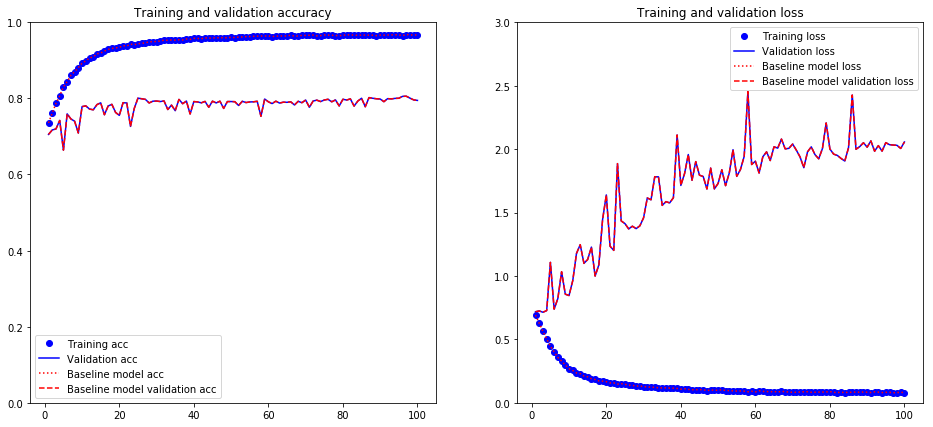

Model 1: 
val_acc:  0.8056666690508525
val_loss:  0.7138564003308614


In [16]:
best_weight_min_loss_m1 = "best_min_loss_m1.hdf5"
best_weight_max_acc_m1 = "best_max_acc_m1.hdf5"
checkpoint_min_loss_m1 = ModelCheckpoint(best_weight_min_loss_m1, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
checkpoint_max_acc_m1 = ModelCheckpoint(best_weight_max_acc_m1, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

# Train the first model and plot the history (normal)
h1 = train_model(m1, X_train_normal, one_hot_labels_train, (X_val_normal,one_hot_labels_val),
                 [checkpoint_min_loss_m1, checkpoint_max_acc_m1],
                "Model 1 : Embedding + Conv1D + LSTM (original)", "100_m1.hdf5", "100_his_m1")
plot_history(h1)

print("Model 1: ")
print("val_acc: ", max(h1.history['val_acc']))
print("val_loss: ", min(h1.history['val_loss']))

This training model 1 used total time 10,790 seconds for 100 epochs and average time 107.9 seconds/epoch.

As you can see from above accuracy and loss graph, accurary is quite stable at 80% rate but loss function incease very quickly that show overfitting of model

<b>Maximum accuracy (97th epoch) = 0.8056<br>
    Minimum loss (3rd epoch)  = 0.7138</b>

### Training model 2 : Embedding + Conv1D + LSTM (modified)

Training  Model 2 : Embedding + Conv1D + LSTM (modified) ...
Train on 158297 samples, validate on 3000 samples
Epoch 1/100
158297/158297 [==============================] - 119s 749us/step - loss: 0.9906 - acc: 0.5651 - val_loss: 0.8448 - val_acc: 0.6063

Epoch 00001: val_loss improved from inf to 0.84476, saving model to best_min_loss_m2.hdf5

Epoch 00001: val_acc improved from -inf to 0.60633, saving model to best_max_acc_m2.hdf5
Epoch 2/100
158297/158297 [==============================] - 115s 723us/step - loss: 0.8497 - acc: 0.6802 - val_loss: 0.8210 - val_acc: 0.6253

Epoch 00002: val_loss improved from 0.84476 to 0.82105, saving model to best_min_loss_m2.hdf5

Epoch 00002: val_acc improved from 0.60633 to 0.62533, saving model to best_max_acc_m2.hdf5
Epoch 3/100
158297/158297 [==============================] - 114s 722us/step - loss: 0.7912 - acc: 0.6962 - val_loss: 0.7497 - val_acc: 0.6700

Epoch 00003: val_loss improved from 0.82105 to 0.74966, saving model to best_min_loss_m2.h

158297/158297 [==============================] - 114s 721us/step - loss: 0.1920 - acc: 0.9259 - val_loss: 0.9729 - val_acc: 0.7993

Epoch 00062: val_loss did not improve from 0.67279

Epoch 00062: val_acc did not improve from 0.80700
Epoch 63/100
158297/158297 [==============================] - 114s 722us/step - loss: 0.1920 - acc: 0.9259 - val_loss: 1.1137 - val_acc: 0.7987

Epoch 00063: val_loss did not improve from 0.67279

Epoch 00063: val_acc did not improve from 0.80700
Epoch 64/100
158297/158297 [==============================] - 114s 721us/step - loss: 0.1947 - acc: 0.9251 - val_loss: 1.0173 - val_acc: 0.8033

Epoch 00064: val_loss did not improve from 0.67279

Epoch 00064: val_acc did not improve from 0.80700
Epoch 65/100
158297/158297 [==============================] - 114s 722us/step - loss: 0.1925 - acc: 0.9266 - val_loss: 0.9249 - val_acc: 0.7930

Epoch 00065: val_loss did not improve from 0.67279

Epoch 00065: val_acc did not improve from 0.80700
Epoch 66/100
158297/15829


Epoch 00094: val_loss did not improve from 0.67279

Epoch 00094: val_acc did not improve from 0.81433
Epoch 95/100
158297/158297 [==============================] - 114s 723us/step - loss: 0.1742 - acc: 0.9336 - val_loss: 0.9711 - val_acc: 0.8053

Epoch 00095: val_loss did not improve from 0.67279

Epoch 00095: val_acc did not improve from 0.81433
Epoch 96/100
158297/158297 [==============================] - 114s 722us/step - loss: 0.1785 - acc: 0.9327 - val_loss: 0.9659 - val_acc: 0.8023

Epoch 00096: val_loss did not improve from 0.67279

Epoch 00096: val_acc did not improve from 0.81433
Epoch 97/100
158297/158297 [==============================] - 114s 723us/step - loss: 0.1781 - acc: 0.9323 - val_loss: 0.9035 - val_acc: 0.8093

Epoch 00097: val_loss did not improve from 0.67279

Epoch 00097: val_acc did not improve from 0.81433
Epoch 98/100
158297/158297 [==============================] - 114s 721us/step - loss: 0.1807 - acc: 0.9332 - val_loss: 0.9247 - val_acc: 0.8047

Epoch 00098

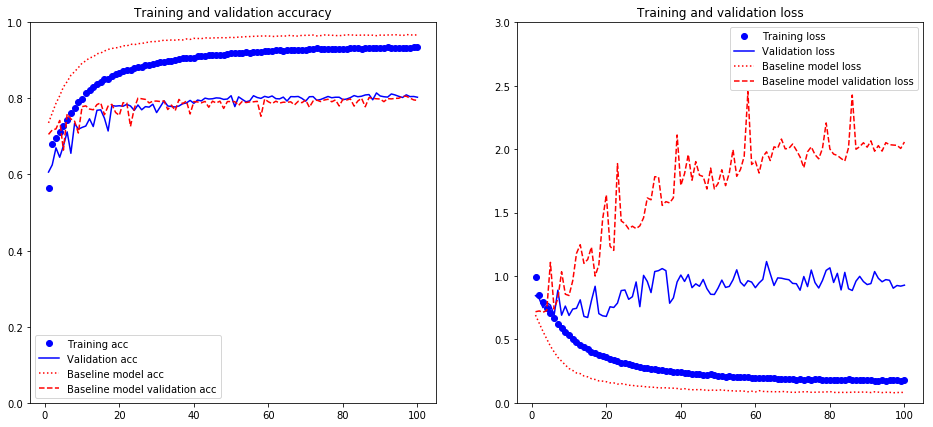

Model 2: 
val_acc:  0.8143333357175191
val_loss:  0.6727931605180104


In [17]:
best_weight_min_loss_m2 = "best_min_loss_m2.hdf5"
best_weight_max_acc_m2 = "best_max_acc_m2.hdf5"
checkpoint_min_loss_m2 = ModelCheckpoint(best_weight_min_loss_m2, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
checkpoint_max_acc_m2 = ModelCheckpoint(best_weight_max_acc_m2, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

# Train the first model and plot the history (normal)
h2 = train_model(m2, X_train_normal, one_hot_labels_train, (X_val_normal,one_hot_labels_val),
                 [checkpoint_min_loss_m2, checkpoint_max_acc_m2],
                "Model 2 : Embedding + Conv1D + LSTM (modified)", "100_m2.hdf5", "100_his_m2")
plot_history(h2)

print("Model 2: ")
print("val_acc: ", max(h2.history['val_acc']))
print("val_loss: ", min(h2.history['val_loss']))

This training model 2 used total time 11,434 seconds for 100 epochs and average time 114.3 seconds/epoch.

As you can see from above accuracy and loss graph, accurary is quite stable at 80% rate but loss function look better than the first model, it show less overfitting.

<b>Maximum accuracy (89th epoch) = 0.8143<br>
    Minimum loss (15th epoch)  = 0.6727</b>

### Training model 3 : Embedding + Conv1D + Stack of GRU

Training  Model 3 : Embedding + Conv1D + Stack of GRU ...
Train on 158297 samples, validate on 3000 samples
Epoch 1/100
158297/158297 [==============================] - 146s 920us/step - loss: 1.0701 - acc: 0.4257 - val_loss: 0.9641 - val_acc: 0.5390

Epoch 00001: val_loss improved from inf to 0.96412, saving model to best_min_loss_m3.hdf5

Epoch 00001: val_acc improved from -inf to 0.53900, saving model to best_max_acc_m3.hdf5
Epoch 2/100
158297/158297 [==============================] - 105s 661us/step - loss: 0.9465 - acc: 0.6394 - val_loss: 0.8620 - val_acc: 0.5927

Epoch 00002: val_loss improved from 0.96412 to 0.86196, saving model to best_min_loss_m3.hdf5

Epoch 00002: val_acc improved from 0.53900 to 0.59267, saving model to best_max_acc_m3.hdf5
Epoch 3/100
158297/158297 [==============================] - 105s 661us/step - loss: 0.8755 - acc: 0.6587 - val_loss: 0.8181 - val_acc: 0.6360

Epoch 00003: val_loss improved from 0.86196 to 0.81808, saving model to best_min_loss_m3.hdf5

158297/158297 [==============================] - 106s 668us/step - loss: 0.1963 - acc: 0.9204 - val_loss: 1.1333 - val_acc: 0.8017

Epoch 00061: val_loss did not improve from 0.70103

Epoch 00061: val_acc did not improve from 0.80967
Epoch 62/100
158297/158297 [==============================] - 106s 668us/step - loss: 0.1987 - acc: 0.9184 - val_loss: 1.2059 - val_acc: 0.8007

Epoch 00062: val_loss did not improve from 0.70103

Epoch 00062: val_acc did not improve from 0.80967
Epoch 63/100
158297/158297 [==============================] - 114s 720us/step - loss: 0.1946 - acc: 0.9209 - val_loss: 1.1230 - val_acc: 0.8023

Epoch 00063: val_loss did not improve from 0.70103

Epoch 00063: val_acc did not improve from 0.80967
Epoch 64/100
158297/158297 [==============================] - 124s 782us/step - loss: 0.1949 - acc: 0.9208 - val_loss: 1.1820 - val_acc: 0.8083

Epoch 00064: val_loss did not improve from 0.70103

Epoch 00064: val_acc did not improve from 0.80967
Epoch 65/100
158297/15829


Epoch 00093: val_loss did not improve from 0.70103

Epoch 00093: val_acc did not improve from 0.81600
Epoch 94/100
158297/158297 [==============================] - 105s 661us/step - loss: 0.1544 - acc: 0.9396 - val_loss: 1.3171 - val_acc: 0.8097

Epoch 00094: val_loss did not improve from 0.70103

Epoch 00094: val_acc did not improve from 0.81600
Epoch 95/100
158297/158297 [==============================] - 105s 661us/step - loss: 0.1577 - acc: 0.9382 - val_loss: 1.1531 - val_acc: 0.8093

Epoch 00095: val_loss did not improve from 0.70103

Epoch 00095: val_acc did not improve from 0.81600
Epoch 96/100
158297/158297 [==============================] - 105s 661us/step - loss: 0.1518 - acc: 0.9402 - val_loss: 1.3583 - val_acc: 0.8080

Epoch 00096: val_loss did not improve from 0.70103

Epoch 00096: val_acc did not improve from 0.81600
Epoch 97/100
158297/158297 [==============================] - 105s 660us/step - loss: 0.1534 - acc: 0.9392 - val_loss: 1.3280 - val_acc: 0.8110

Epoch 00097

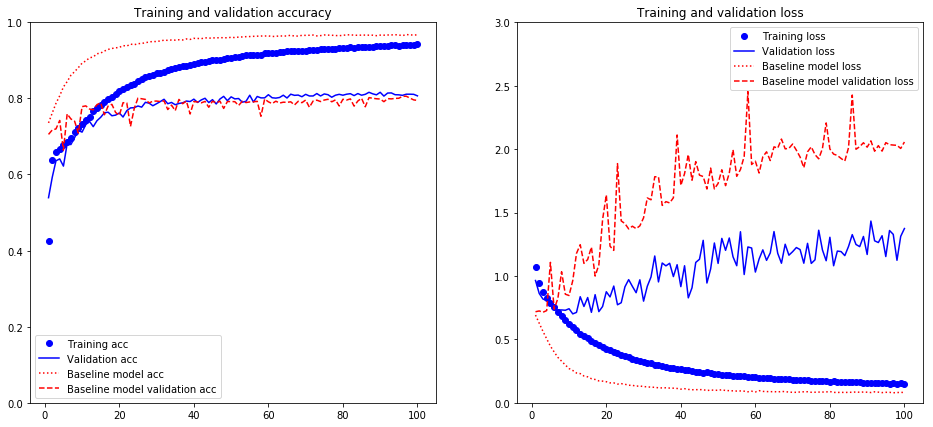

Model 3: 
val_acc:  0.8160000038146973
val_loss:  0.7010288740793864


In [18]:
best_weight_min_loss_m3 = "best_min_loss_m3.hdf5"
best_weight_max_acc_m3 = "best_max_acc_m3.hdf5"
checkpoint_min_loss_m3 = ModelCheckpoint(best_weight_min_loss_m3, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
checkpoint_max_acc_m3 = ModelCheckpoint(best_weight_max_acc_m3, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

# Train the first model and plot the history (normal)
h3 = train_model(m3, X_train_normal, one_hot_labels_train, (X_val_normal,one_hot_labels_val),
                 [checkpoint_min_loss_m3, checkpoint_max_acc_m3],
                "Model 3 : Embedding + Conv1D + Stack of GRU", "100_m3.hdf5", "100_his_m3", bs = 1024)
plot_history(h3)

print("Model 3: ")
print("val_acc: ", max(h3.history['val_acc']))
print("val_loss: ", min(h3.history['val_loss']))

This training model 3 used total time 10,899 seconds for 100 epochs and average time 109.0 seconds/epoch.

As you can see from above accuracy and loss graph, accurary is quite stable at 80% rate and loss function look better than the first model but more overfit than the second model.

<b>Maximum accuracy (90th epoch) = 0.8160<br>
    Minimum loss (11th epoch)  = 0.7010</b>

### Training model 4 : Embedding + Conv1D + Bidirectional LSTM

Training  Model 4 : Embedding + Conv1D + Bidirectional LSTM ...
Train on 158297 samples, validate on 3000 samples
Epoch 1/100
158297/158297 [==============================] - 163s 1ms/step - loss: 1.0202 - acc: 0.5525 - val_loss: 0.8785 - val_acc: 0.5707

Epoch 00001: val_loss improved from inf to 0.87849, saving model to best_min_loss_m4.hdf5

Epoch 00001: val_acc improved from -inf to 0.57067, saving model to best_max_acc_m4.hdf5
Epoch 2/100
158297/158297 [==============================] - 104s 660us/step - loss: 0.8874 - acc: 0.6963 - val_loss: 0.8200 - val_acc: 0.5997

Epoch 00002: val_loss improved from 0.87849 to 0.82003, saving model to best_min_loss_m4.hdf5

Epoch 00002: val_acc improved from 0.57067 to 0.59967, saving model to best_max_acc_m4.hdf5
Epoch 3/100
158297/158297 [==============================] - 104s 659us/step - loss: 0.8345 - acc: 0.6966 - val_loss: 0.7925 - val_acc: 0.6330

Epoch 00003: val_loss improved from 0.82003 to 0.79250, saving model to best_min_loss_m4.


Epoch 00029: val_loss did not improve from 0.70803

Epoch 00029: val_acc did not improve from 0.78933
Epoch 30/100
158297/158297 [==============================] - 104s 658us/step - loss: 0.3506 - acc: 0.8605 - val_loss: 0.9729 - val_acc: 0.7800

Epoch 00030: val_loss did not improve from 0.70803

Epoch 00030: val_acc did not improve from 0.78933
Epoch 31/100
158297/158297 [==============================] - 104s 659us/step - loss: 0.3412 - acc: 0.8653 - val_loss: 0.9736 - val_acc: 0.7827

Epoch 00031: val_loss did not improve from 0.70803

Epoch 00031: val_acc did not improve from 0.78933
Epoch 32/100
158297/158297 [==============================] - 104s 658us/step - loss: 0.3363 - acc: 0.8681 - val_loss: 0.8659 - val_acc: 0.7933

Epoch 00032: val_loss did not improve from 0.70803

Epoch 00032: val_acc improved from 0.78933 to 0.79333, saving model to best_max_acc_m4.hdf5
Epoch 33/100
158297/158297 [==============================] - 104s 658us/step - loss: 0.3270 - acc: 0.8725 - val_l

158297/158297 [==============================] - 119s 750us/step - loss: 0.1842 - acc: 0.9293 - val_loss: 1.2850 - val_acc: 0.8067

Epoch 00094: val_loss did not improve from 0.70803

Epoch 00094: val_acc did not improve from 0.81300
Epoch 95/100
158297/158297 [==============================] - 118s 748us/step - loss: 0.1766 - acc: 0.9318 - val_loss: 1.2729 - val_acc: 0.8050

Epoch 00095: val_loss did not improve from 0.70803

Epoch 00095: val_acc did not improve from 0.81300
Epoch 96/100
158297/158297 [==============================] - 119s 749us/step - loss: 0.1775 - acc: 0.9319 - val_loss: 1.3250 - val_acc: 0.8010

Epoch 00096: val_loss did not improve from 0.70803

Epoch 00096: val_acc did not improve from 0.81300
Epoch 97/100
158297/158297 [==============================] - 119s 749us/step - loss: 0.1787 - acc: 0.9313 - val_loss: 1.1516 - val_acc: 0.8103

Epoch 00097: val_loss did not improve from 0.70803

Epoch 00097: val_acc did not improve from 0.81300
Epoch 98/100
158297/15829

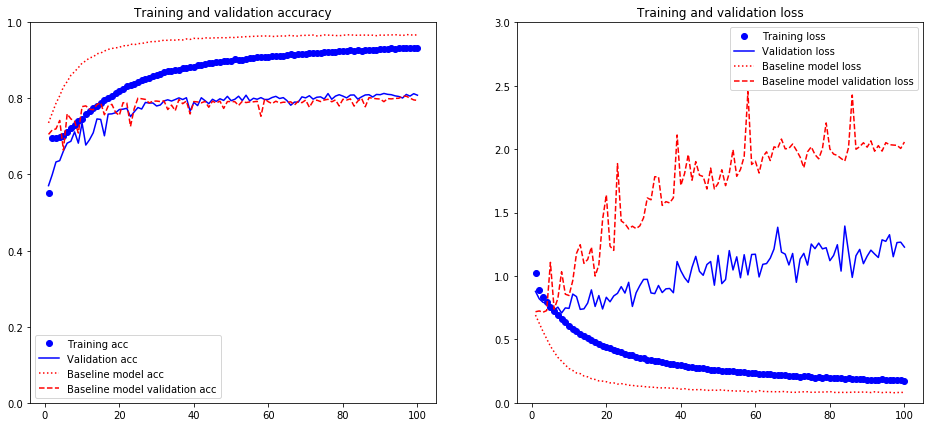

Model 4: 
val_acc:  0.8129999971389771
val_loss:  0.7080348100662232


In [19]:
best_weight_min_loss_m4 = "best_min_loss_m4.hdf5"
best_weight_max_acc_m4 = "best_max_acc_m4.hdf5"
checkpoint_min_loss_m4 = ModelCheckpoint(best_weight_min_loss_m4, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
checkpoint_max_acc_m4 = ModelCheckpoint(best_weight_max_acc_m4, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

# Train the first model and plot the history (normal)
h4 = train_model(m4, X_train_normal, one_hot_labels_train, (X_val_normal,one_hot_labels_val),
                 [checkpoint_min_loss_m4, checkpoint_max_acc_m4],
                "Model 4 : Embedding + Conv1D + Bidirectional LSTM", "100_m4.hdf5", "100_his_m4", bs = 1024)
plot_history(h4)

print("Model 4: ")
print("val_acc: ", max(h4.history['val_acc']))
print("val_loss: ", min(h4.history['val_loss']))

This training model 4 used total time 11,466 seconds for 100 epochs and average time 114.7 seconds/epoch.

As you can see from above accuracy and loss graph, accurary is quite stable at 80% rate and loss function look better than the first model but more overfit than the second model.

<b>Maximum accuracy (91th epoch) = 0.8129<br>
    Minimum loss (8th epoch)  = 0.7080</b>

## 6. Evaluation

 I use this function to showed efficiecy of each model by using the same validation set to compare min_loss and max_acc of each model.

In [20]:
# Function to display confusion matrix, classification report, accuracy, specification, sensitivity, and false negative
def display_results(path):
    # Load model from given path
    m = load_model(path)
    
    # Get the true and predicted values
    y_true = val_df['label'].values
    y_pred = m.predict(X_val_normal).argmax(1)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        # Create confusion matrix
        cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
        print('Confusion matrix:')
        print(cm)
        print('')
        
        # Calculate accuracy
        a = accuracy_score(y_true, y_pred)
        print('Accuracy: {:.4f}'.format(a))
        print('')
    
    # Clear tensorflow backend session and delete m variable
    K.clear_session()
    del m

### Selcetion the best of all

In [21]:
print('Result from the min_loss model 1')
display_results(best_weight_min_loss_m1)
print('=====================================')

print('Result from the max_acc model 1')
display_results(best_weight_max_acc_m1)
print('=====================================')

Result from the min_loss model 1
Confusion matrix:
[[798 175  27]
 [245 671  84]
 [ 87 223 690]]

Accuracy: 0.7197

Result from the max_acc model 1
Confusion matrix:
[[841  58 101]
 [148 668 184]
 [ 53  39 908]]

Accuracy: 0.8057



In [22]:
print('Result from the min_loss model 2')
display_results(best_weight_min_loss_m2)
print('=====================================')

print('Result from the max_acc model 2')
display_results(best_weight_max_acc_m2)
print('=====================================')

Result from the min_loss model 2
Confusion matrix:
[[758 177  65]
 [131 707 162]
 [ 32 123 845]]

Accuracy: 0.7700

Result from the max_acc model 2
Confusion matrix:
[[865  62  73]
 [149 672 179]
 [ 41  53 906]]

Accuracy: 0.8143



In [23]:
print('Result from the min_loss model 3')
display_results(best_weight_min_loss_m3)
print('=====================================')

print('Result from the max_acc model 3')
display_results(best_weight_max_acc_m3)
print('=====================================')

Result from the min_loss model 3
Confusion matrix:
[[750 217  33]
 [182 717 101]
 [ 52 222 726]]

Accuracy: 0.7310

Result from the max_acc model 3
Confusion matrix:
[[848  69  83]
 [137 681 182]
 [ 46  35 919]]

Accuracy: 0.8160



In [24]:
print('Result from the min_loss model 4')
display_results(best_weight_min_loss_m4)
print('=====================================')

print('Result from the max_acc model 4')
display_results(best_weight_max_acc_m4)
print('=====================================')

Result from the min_loss model 4
Confusion matrix:
[[726 237  37]
 [202 667 131]
 [ 37 220 743]]

Accuracy: 0.7120

Result from the max_acc model 4
Confusion matrix:
[[880  50  70]
 [185 662 153]
 [ 55  48 897]]

Accuracy: 0.8130



As the result, Top 2 best models (consider from high accuracy) are:

1. max_acc Model 3 Embedding + Conv1D + Stack of GRU (at 89th epoch)
    * Accuracy = 81.60%
    * Loss = 1.1694
2. max_acc Model 2 Embedding + Conv1D + LSTM (modified) (at 124th epoch)
    * Accuracy = 81.43%
    * Loss = 0.9556

From above comparison, the best model that I selected was <b>Model 2 Embedding + Conv1D + LSTM (modified)</b> because its accuracy is just a little bit different from model 3 but its loss is lower.

### Defining my preprocess function

By observing the datset, I found some special mark such as <b>'\r\n' '&#039\;' '&amp\;'</b>. So, I tried to create my own to decode those special mark using 'BeautifulSoup' function and extract some short form of word (ex isn't = is not). I also <b>removed some stopwords</b> in review because those words may occur many times but it doesn't important to model to analyze. However, I defined <b>exception_list for some stopword that is important such as 'not', 'no', and 'nor'</b>, because I believe that negative form in sentence should be important to predict rating review ('good' = positive but 'not good' = negative).

In [25]:
# Dictionary to extract short form of some words
dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
        "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
        "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
        "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
        "mustn't":"must not", "dnt":"do not", "n":"and", "wasnt":"was not", "thks":"thanks", "thk":"thanks",
        "thank":"thanks", "re":"are", "cant":"can not", "thx":"thanks", "it's": "it is", "i'm": "i am",
        "he's": "he is", "she's": "she is", "you're": "you are", "we're": "we are", "they're": "they are",
        "i've": "i have", "you've": "you have", "we've": "we have", "they've": "they have"}
# Exception list of stopword
exception_list = ["not", "nor", "no", "than", "very"]
replace_pattern = re.compile(r'\b(' + '|'.join(dic.keys()) + r')\b')
tok = WordPunctTokenizer()

# List of stopword in english
stop_words = set(stopwords.words('english'))

def preprocess_func(text):
    # Decode lxml special mark
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    
    # Lowercase all character
    lower_case = bom_removed.lower()
    # Extract short form word
    pat_handled = replace_pattern.sub(lambda x: dic[x.group()], lower_case)
    # Remove stopword
    rm_stopwords = [w for w in tok.tokenize(pat_handled) if (not w in stop_words) or (w in exception_list)]
    # Getting only alphabet
    letters_only = [word for word in rm_stopwords if word.isalpha()]
    return " ".join(letters_only)

This is example of text before and after preprocessing:

In [26]:
sample_text = train_df.sample()['review'].values
print("Original text: ")
print(sample_text)
print()
print("Preprocessed text: ")
print(preprocess_func(sample_text[0]))

Original text: 
['"If you don&#039;t want to get pregnant, then this birth control works just fine. Downsides for me: longer periods. I was bloated for a good 2 months. I read to try and stick it out for 3 months and bloating would subside, and for the most part it did. Last but not least, and for me the worst, the CYSTIC ACNE!! Uggghh I haven&#039;t have acne in 3 yrs and as soon, as soon! As I switched to this BC I started getting them all over, with cystic ones mainly on my jaw line. I absolutely hate it and will be switching BC this week!!!"']

Preprocessed text: 
not want get pregnant birth control works fine downsides longer periods bloated good months read try stick months bloating would subside part last not least worst cystic acne uggghh not acne yrs soon soon switched bc started getting cystic ones mainly jaw line absolutely hate switching bc week


Then, I apply preprocess function to all dataset and tokenize them.

In [27]:
# Apply preprocess function to each set
X_all_train_pre = data['review'].apply(lambda x : preprocess_func(x))
X_train_pre = train_df['review'].apply(lambda x : preprocess_func(x))
X_val_pre = val_df['review'].apply(lambda x : preprocess_func(x))

# Read a part of the reviews and create training sequences (x_train)
tokenizer_pre = Tokenizer(num_words = max_feature)
tokenizer_pre.fit_on_texts(X_all_train_pre)

X_train_pre = pad_sequences(tokenizer.texts_to_sequences(X_train_pre), maxlen = max_len)
X_val_pre = pad_sequences(tokenizer.texts_to_sequences(X_val_pre), maxlen = max_len)

### Word2Vec Embedding

Instead of learning word embeddings jointly with the problem you want to solve, you can load embedding vectors from a precomputed embedding space that you know is highly structured and exhibits useful properties—that captures generic aspects of language structure in case that that you may don't have enough dataset to train your own efficient embbeding layer.

Instead of training the embedding layer, we can first separately learn word embeddings and then pass to the embedding layer. This approach also allows to use any pre-trained word embedding and also saves the time in training the classification model. <b>I will use the Gensim implementation of Word2Vec in this case.</b>

Ref: https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456

In [28]:
# Sentence to list function
def preprocess_w2v(lines):
    review_lines = list()
    
    for line in lines:
        tokens = word_tokenize(line)
        tokens = [w.lower() for w in tokens]
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        review_lines.append(stripped)
    
    return review_lines

In [29]:
# Apply function to all data
all_w2v = preprocess_w2v(data['review'].values.tolist())
train_w2v = preprocess_w2v(train_df['review'].values.tolist())
val_w2v = preprocess_w2v(val_df['review'].values.tolist())

In [30]:
# Train Word2Vec model
model = gensim.models.Word2Vec(sentences=all_w2v, size=embedded_dim, window=5, workers=4, min_count=1)

words = list(model.wv.vocab)
print('Vocabulary size: %d' % len(words))

Vocabulary size: 67444


In [31]:
# Save word2vec model
filename = 'embedding_word2vec.txt'
model.wv.save_word2vec_format(filename, binary=False)

In [32]:
# Load word2vec model
embeddings_index = {}
f = open(os.path.join('', 'embedding_word2vec.txt'), encoding = 'utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

In [33]:
tokenizer_obj = Tokenizer(num_words = max_feature)
tokenizer_obj.fit_on_texts(all_w2v)
sequences = tokenizer_obj.texts_to_sequences(train_w2v)
sequences_val = tokenizer_obj.texts_to_sequences(val_w2v)

train_pad = pad_sequences(sequences, maxlen=max_len)
val_pad = pad_sequences(sequences_val, maxlen=max_len)

word_index = tokenizer_obj.word_index
print('Found %s unique tokens.' % len(word_index))

Found 67444 unique tokens.


In [34]:
num_words = len(word_index)+1
embedding_matrix = np.zeros((num_words, embedded_dim))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Comparing Without preprocess / Preprocess / Word2Vec

I compared my best architecture that was trained by dataset without preprocessing, dataset with preprocessing, and embedding layer with Word2Vec pre-train algorithm.

In [35]:
def reinitial_best_model(isw2v=False):
    # Re-initial the best model
    m = Sequential()
    if(isw2v):
        m.add(Embedding(num_words, embedded_dim,
                         embeddings_initializer = Constant(embedding_matrix),
                         input_length = max_len, trainable = False))
    else :
        m.add(Embedding(max_feature, embedded_dim, input_length = max_len))
    m.add(Dropout(0.3))
    m.add(Conv1D(32, 11, activation='relu'))
    m.add(MaxPooling1D(5))
    m.add(Conv1D(32, 11, activation='relu'))
    m.add(LSTM(16, dropout = 0.5, recurrent_dropout = 0.5))
    m.add(Dropout(0.3))
    m.add(Dense(16, activation = 'relu'))
    m.add(Dropout(0.3))
    m.add(Dense(3, activation = 'softmax'))
    m.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
    
    return m

In [36]:
# Re-initial the best model
mbest = reinitial_best_model()

# Train the best model with preprocessed data
best_weight_min_loss_mbest_pre = "best_min_loss_mbest_pre.hdf5"
best_weight_max_acc_mbest_pre = "best_max_acc_mbest_pre.hdf5"
checkpoint_min_loss_mbest_pre = ModelCheckpoint(best_weight_min_loss_mbest_pre, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
checkpoint_max_acc_mbest_pre = ModelCheckpoint(best_weight_max_acc_mbest_pre, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

# Train the first model and plot the history (normal)
h_pre = train_model(mbest, X_train_pre, one_hot_labels_train, (X_val_pre, one_hot_labels_val),
                 [checkpoint_min_loss_mbest_pre, checkpoint_max_acc_mbest_pre],
                "Model 2 with preprocessed data", "100_mbest_pre.hdf5", "100_his_mbest_pre")

Training  Model 2 with preprocessed data ...
Train on 158297 samples, validate on 3000 samples
Epoch 1/100
158297/158297 [==============================] - 196s 1ms/step - loss: 0.9899 - acc: 0.5766 - val_loss: 0.8509 - val_acc: 0.5877

Epoch 00001: val_loss improved from inf to 0.85093, saving model to best_min_loss_mbest_pre.hdf5

Epoch 00001: val_acc improved from -inf to 0.58767, saving model to best_max_acc_mbest_pre.hdf5
Epoch 2/100
158297/158297 [==============================] - 116s 731us/step - loss: 0.8572 - acc: 0.7023 - val_loss: 0.8814 - val_acc: 0.5583

Epoch 00002: val_loss did not improve from 0.85093

Epoch 00002: val_acc did not improve from 0.58767
Epoch 3/100
158297/158297 [==============================] - 116s 730us/step - loss: 0.7997 - acc: 0.7046 - val_loss: 0.7507 - val_acc: 0.6607

Epoch 00003: val_loss improved from 0.85093 to 0.75065, saving model to best_min_loss_mbest_pre.hdf5

Epoch 00003: val_acc improved from 0.58767 to 0.66067, saving model to best_m

158297/158297 [==============================] - 144s 907us/step - loss: 0.2953 - acc: 0.8828 - val_loss: 0.8325 - val_acc: 0.7860

Epoch 00031: val_loss did not improve from 0.69119

Epoch 00031: val_acc did not improve from 0.78667
Epoch 32/100
158297/158297 [==============================] - 144s 909us/step - loss: 0.2889 - acc: 0.8837 - val_loss: 0.7866 - val_acc: 0.7870

Epoch 00032: val_loss did not improve from 0.69119

Epoch 00032: val_acc improved from 0.78667 to 0.78700, saving model to best_max_acc_mbest_pre.hdf5
Epoch 33/100
158297/158297 [==============================] - 144s 908us/step - loss: 0.2857 - acc: 0.8866 - val_loss: 0.8756 - val_acc: 0.7900

Epoch 00033: val_loss did not improve from 0.69119

Epoch 00033: val_acc improved from 0.78700 to 0.79000, saving model to best_max_acc_mbest_pre.hdf5
Epoch 34/100
158297/158297 [==============================] - 145s 918us/step - loss: 0.2731 - acc: 0.8897 - val_loss: 0.8143 - val_acc: 0.7950

Epoch 00034: val_loss did not


Epoch 00095: val_loss did not improve from 0.69119

Epoch 00095: val_acc did not improve from 0.80667
Epoch 96/100
158297/158297 [==============================] - 126s 799us/step - loss: 0.1864 - acc: 0.9283 - val_loss: 0.9410 - val_acc: 0.8037

Epoch 00096: val_loss did not improve from 0.69119

Epoch 00096: val_acc did not improve from 0.80667
Epoch 97/100
158297/158297 [==============================] - 126s 794us/step - loss: 0.1824 - acc: 0.9299 - val_loss: 0.9022 - val_acc: 0.8033

Epoch 00097: val_loss did not improve from 0.69119

Epoch 00097: val_acc did not improve from 0.80667
Epoch 98/100
158297/158297 [==============================] - 126s 798us/step - loss: 0.1781 - acc: 0.9309 - val_loss: 0.9184 - val_acc: 0.8027

Epoch 00098: val_loss did not improve from 0.69119

Epoch 00098: val_acc did not improve from 0.80667
Epoch 99/100
158297/158297 [==============================] - 123s 779us/step - loss: 0.1794 - acc: 0.9315 - val_loss: 0.9728 - val_acc: 0.7960

Epoch 00099

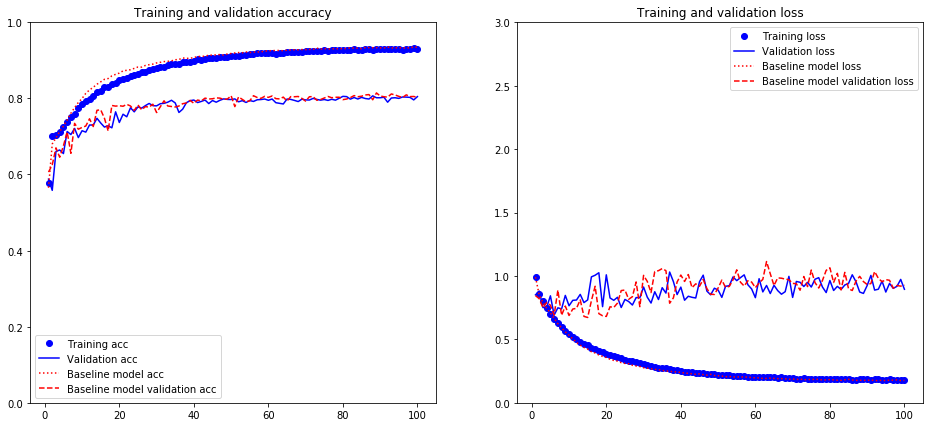

Model 2 with preprocessed data: 
val_acc:  0.8066666644414265
val_loss:  0.6911947611967723


In [37]:
plot_history(h_pre, "100_his_m2")

print("Model 2 with preprocessed data: ")
print("val_acc: ", max(h_pre.history['val_acc']))
print("val_loss: ", min(h_pre.history['val_loss']))

# Clear model and session
del mbest
K.clear_session()

As the result, <b>this model doesn't perform different from model that was trained by dataset without preprocessing</b>. Moreover, it look like to get less accuracy and higher loss.

Training  Model 2 with Word2Vec ...
Train on 158297 samples, validate on 3000 samples
Epoch 1/100
158297/158297 [==============================] - 109s 689us/step - loss: 1.1047 - acc: 0.2788 - val_loss: 1.0988 - val_acc: 0.3340

Epoch 00001: val_loss improved from inf to 1.09877, saving model to best_min_loss_mbest_w2v.hdf5

Epoch 00001: val_acc improved from -inf to 0.33400, saving model to best_max_acc_mbest_w2v.hdf5
Epoch 2/100
158297/158297 [==============================] - 70s 444us/step - loss: 1.0995 - acc: 0.1948 - val_loss: 1.0981 - val_acc: 0.3430

Epoch 00002: val_loss improved from 1.09877 to 1.09812, saving model to best_min_loss_mbest_w2v.hdf5

Epoch 00002: val_acc improved from 0.33400 to 0.34300, saving model to best_max_acc_mbest_w2v.hdf5
Epoch 3/100
158297/158297 [==============================] - 71s 449us/step - loss: 1.0989 - acc: 0.1880 - val_loss: 1.0969 - val_acc: 0.3477

Epoch 00003: val_loss improved from 1.09812 to 1.09690, saving model to best_min_loss_mbe

C:\Users\Pasin\Anaconda3\envs\py36\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.027359). Check your callbacks.
  % delta_t_median)


158297/158297 [==============================] - 191s 1ms/step - loss: 1.0614 - acc: 0.4444 - val_loss: 1.0117 - val_acc: 0.4867

Epoch 00005: val_loss improved from 1.07211 to 1.01173, saving model to best_min_loss_mbest_w2v.hdf5

Epoch 00005: val_acc improved from 0.41633 to 0.48667, saving model to best_max_acc_mbest_w2v.hdf5
Epoch 6/100
158297/158297 [==============================] - 81s 509us/step - loss: 1.0150 - acc: 0.5651 - val_loss: 0.9529 - val_acc: 0.5183

Epoch 00006: val_loss improved from 1.01173 to 0.95293, saving model to best_min_loss_mbest_w2v.hdf5

Epoch 00006: val_acc improved from 0.48667 to 0.51833, saving model to best_max_acc_mbest_w2v.hdf5
Epoch 7/100
158297/158297 [==============================] - 72s 456us/step - loss: 0.9755 - acc: 0.5987 - val_loss: 0.8997 - val_acc: 0.5717

Epoch 00007: val_loss improved from 0.95293 to 0.89973, saving model to best_min_loss_mbest_w2v.hdf5

Epoch 00007: val_acc improved from 0.51833 to 0.57167, saving model to best_max_


Epoch 00032: val_acc improved from 0.66867 to 0.67567, saving model to best_max_acc_mbest_w2v.hdf5
Epoch 33/100
158297/158297 [==============================] - 65s 409us/step - loss: 0.7844 - acc: 0.6611 - val_loss: 0.7702 - val_acc: 0.6440

Epoch 00033: val_loss did not improve from 0.73970

Epoch 00033: val_acc did not improve from 0.67567
Epoch 34/100
158297/158297 [==============================] - 65s 410us/step - loss: 0.7872 - acc: 0.6564 - val_loss: 0.7361 - val_acc: 0.6807

Epoch 00034: val_loss improved from 0.73970 to 0.73607, saving model to best_min_loss_mbest_w2v.hdf5

Epoch 00034: val_acc improved from 0.67567 to 0.68067, saving model to best_max_acc_mbest_w2v.hdf5
Epoch 35/100
158297/158297 [==============================] - 65s 410us/step - loss: 0.7846 - acc: 0.6608 - val_loss: 0.7725 - val_acc: 0.6520

Epoch 00035: val_loss did not improve from 0.73607

Epoch 00035: val_acc did not improve from 0.68067
Epoch 36/100
158297/158297 [==============================] - 6

Epoch 64/100
158297/158297 [==============================] - 65s 411us/step - loss: 0.7547 - acc: 0.6758 - val_loss: 0.7351 - val_acc: 0.6747

Epoch 00064: val_loss did not improve from 0.72373

Epoch 00064: val_acc did not improve from 0.69067
Epoch 65/100
158297/158297 [==============================] - 65s 409us/step - loss: 0.7557 - acc: 0.6754 - val_loss: 0.7216 - val_acc: 0.6847

Epoch 00065: val_loss improved from 0.72373 to 0.72164, saving model to best_min_loss_mbest_w2v.hdf5

Epoch 00065: val_acc did not improve from 0.69067
Epoch 66/100
158297/158297 [==============================] - 65s 409us/step - loss: 0.7551 - acc: 0.6785 - val_loss: 0.7207 - val_acc: 0.6880

Epoch 00066: val_loss improved from 0.72164 to 0.72069, saving model to best_min_loss_mbest_w2v.hdf5

Epoch 00066: val_acc did not improve from 0.69067
Epoch 67/100
158297/158297 [==============================] - 65s 409us/step - loss: 0.7528 - acc: 0.6778 - val_loss: 0.7273 - val_acc: 0.6837

Epoch 00067: val_l

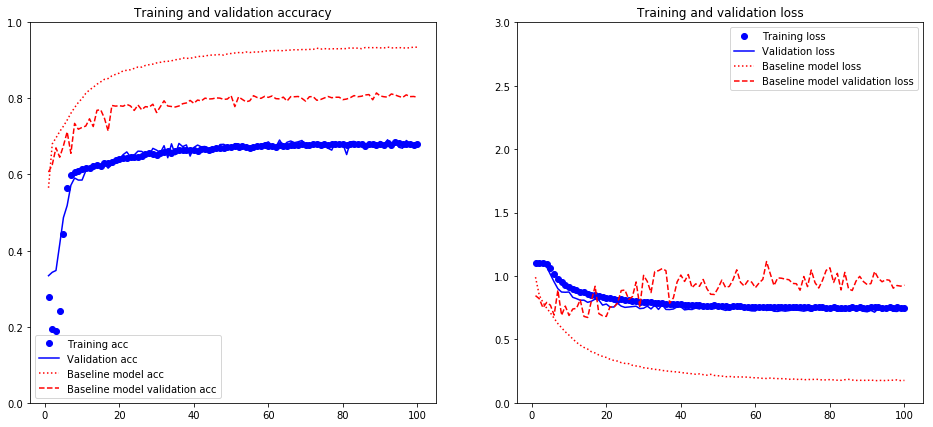

Model 2 with word2vec: 
val_acc:  0.6913333427111308
val_loss:  0.7143282392819722


In [38]:
# Re-initial the best model
mbest = reinitial_best_model(True)

# Train the best model with preprocessed data
best_weight_min_loss_mbest_w2v = "best_min_loss_mbest_w2v.hdf5"
best_weight_max_acc_mbest_w2v = "best_max_acc_mbest_w2v.hdf5"
checkpoint_min_loss_mbest_w2v = ModelCheckpoint(best_weight_min_loss_mbest_w2v, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
checkpoint_max_acc_mbest_w2v = ModelCheckpoint(best_weight_max_acc_mbest_w2v, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

# Train the first model and plot the history (normal)
h_w2v = train_model(mbest, train_pad, one_hot_labels_train, (val_pad, one_hot_labels_val),
                 [checkpoint_min_loss_mbest_w2v, checkpoint_max_acc_mbest_w2v],
                "Model 2 with Word2Vec", "100_mbest_w2v.hdf5", "100_his_mbest_w2v", bs=1024)
plot_history(h_w2v, "100_his_m2")

print("Model 2 with word2vec: ")
print("val_acc: ", max(h_w2v.history['val_acc']))
print("val_loss: ", min(h_w2v.history['val_loss']))

From above graphs, the accuracy and loss of both training-set and validation-set are very close to each other. We can say that <b>this model doesn't show overfitting, but at the same time its performance is less than the original model</b>.

So, I chosen the model that was trained by <b>dataset without preprocessing as by best model</b>.

##  7. Results and Discussion

### Final model with test set

I imported the test-set data and decided to use balanced test-set to evaluate my final model.

In [39]:
# Read the training data
test = pd.read_csv(r'./drugsComTest_raw.csv')

# Create labels based on the original article: Grässer et al. (2018)
r_test = test['rating']
r_replace_test = r_test.replace({ 0 : 0, 1 : 0, 2: 0, 3: 0, 4: 0 })
r_replace_test = r_replace_test.replace({ 5 : 1, 6 : 1})
r_replace_test = r_replace_test.replace({ 7 : 2, 8 : 2, 9 : 2, 10 : 2})

# Add the label column to the data
test['label'] = r_replace_test

# Plot distribution of labels
print(test['label'].value_counts())

2    35440
0    13497
1     4829
Name: label, dtype: int64


In [40]:
# Group records by level feature
g = data.groupby('label')

# Sample records equal to SIZE//2 for each group for balancing the dataset
test_df = g.apply(lambda x: x.sample(4829, random_state = seed))

In [41]:
# Read a part of the reviews and create training sequences (x_train)
X_test_normal = pad_sequences(tokenizer.texts_to_sequences(test_df['review']), maxlen = max_len)

As same as the 'display_results' function that I define above, but this time I use test set (53,766 records) that is unseen data to evaluate my final model for getting the final score of my best model.

In [42]:
print('Result from the BEST model')
print('TEST SET')

# Load the final model from the given path
m_final = load_model("best_max_acc_m2.hdf5")

# Get the true and predicted values
y_true = test_df['label'].values
y_pred = m_final.predict(X_test_normal).argmax(1)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    print('Confusion matrix:')
    print(cm)
    print('')

    # Calculate accuracy
    a = accuracy_score(y_true, y_pred)
    print('Accuracy: {:.4f}'.format(a))
    print('')
    
    # Display Classification report
    cr = classification_report(y_true, y_pred)
    print('Classification report:')
    print(cr)

Result from the BEST model
TEST SET
Confusion matrix:
[[4666   68   95]
 [ 155 4477  197]
 [  98   85 4646]]

Accuracy: 0.9518

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4829
           1       0.97      0.93      0.95      4829
           2       0.94      0.96      0.95      4829

   micro avg       0.95      0.95      0.95     14487
   macro avg       0.95      0.95      0.95     14487
weighted avg       0.95      0.95      0.95     14487



## 8. Conclusions

From this case, I have learned about how to use neural networks to process text data. In this case, using pretraining model doesn't help as the previous case (Case 2). I assume that maybe words in drug review are too specific, so it can't fit with pre-train model that use general word in training.

Another topic that I have leraned in this assignment is about imbalance dataset. Class_weight defining is technique that I learn in this case to fight with imbalance data. As you can see from the final model evaluation, <b>I use balanced test-set to check that the model is bias or not</b>, and the result show that the  model perform very good to every class without bias.

This case quite take long time for training each model, so I hoped that if I have more time I can try more architectures model and find preprocessing function that can improve performance of my model.